In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools


TensorFlow version 2.11.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.10.0 is the most recent version that has been tested.


In [2]:
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 50

keras version  2.11.0


In [4]:
dfMet = pd.read_csv("metadata.csv")
dfSig = pd.read_csv("signals.csv")

In [5]:
dfMet.head(5)

,user_snippet,x-axis__sum_values,x-axis__median,x-axis__mean,x-axis__length,x-axis__standard_deviation,x-axis__variance,x-axis__root_mean_square,x-axis__maximum,x-axis__absolute_maximum,...,z-axis__median,z-axis__mean,z-axis__length,z-axis__standard_deviation,z-axis__variance,z-axis__root_mean_square,z-axis__maximum,z-axis__absolute_maximum,z-axis__minimum,activity
0,1008_0,-208.0,-1.8,-2.1,100.0,4.7,22.1,5.1,7.5,16.0,...,1.8,2.4,100.0,4.0,16.0,4.7,14.3,14.3,-4.4,Upstairs
1,1008_1,29.0,0.5,0.3,100.0,2.7,7.0,2.7,5.9,8.8,...,2.3,2.6,100.0,3.1,9.9,4.1,14.6,14.6,-5.8,Upstairs
2,1008_2,-160.3,-1.0,-1.6,100.0,5.7,32.6,5.9,9.8,17.6,...,-0.1,0.2,100.0,4.6,20.9,4.6,9.5,9.5,-7.3,Walking
3,1008_3,-138.3,-1.9,-1.4,100.0,4.1,16.5,4.3,6.5,12.7,...,1.5,2.6,100.0,5.8,33.3,6.3,14.6,14.6,-6.7,Jogging
4,1008_4,-184.3,-2.0,-1.8,100.0,3.8,14.6,4.2,7.7,8.7,...,1.6,2.2,100.0,5.8,33.8,6.2,18.2,18.2,-9.4,Jogging


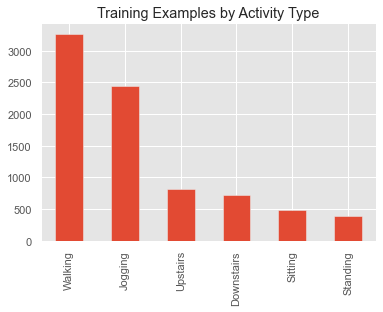

In [6]:
# Show how many activity exists for each of the six activities
dfMet['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()


In [7]:
# merge signals and metadata dataframes on user_id
merged = pd.merge(dfSig, dfMet[['user_snippet', 'activity']], on='user_snippet')

# add a new column 'activity_type_by_user' based on 'activity_type'

merged.head(400)
merged.to_csv('signalsMerged.csv', index=False)


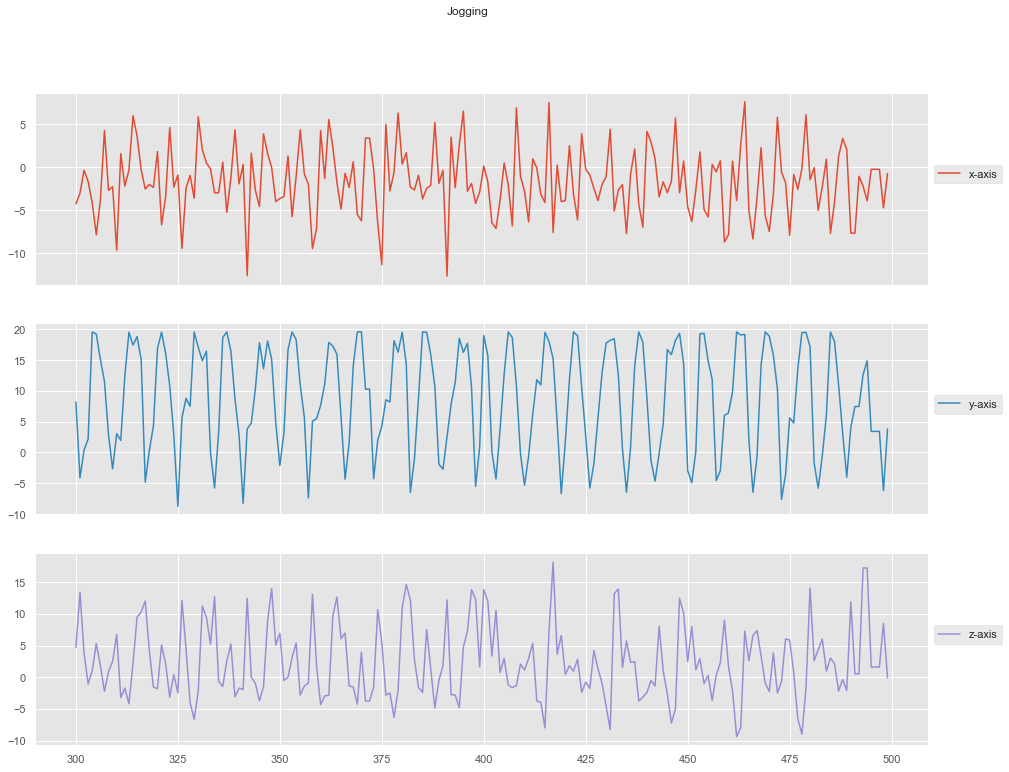

In [8]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plot_activity("Jogging", merged)

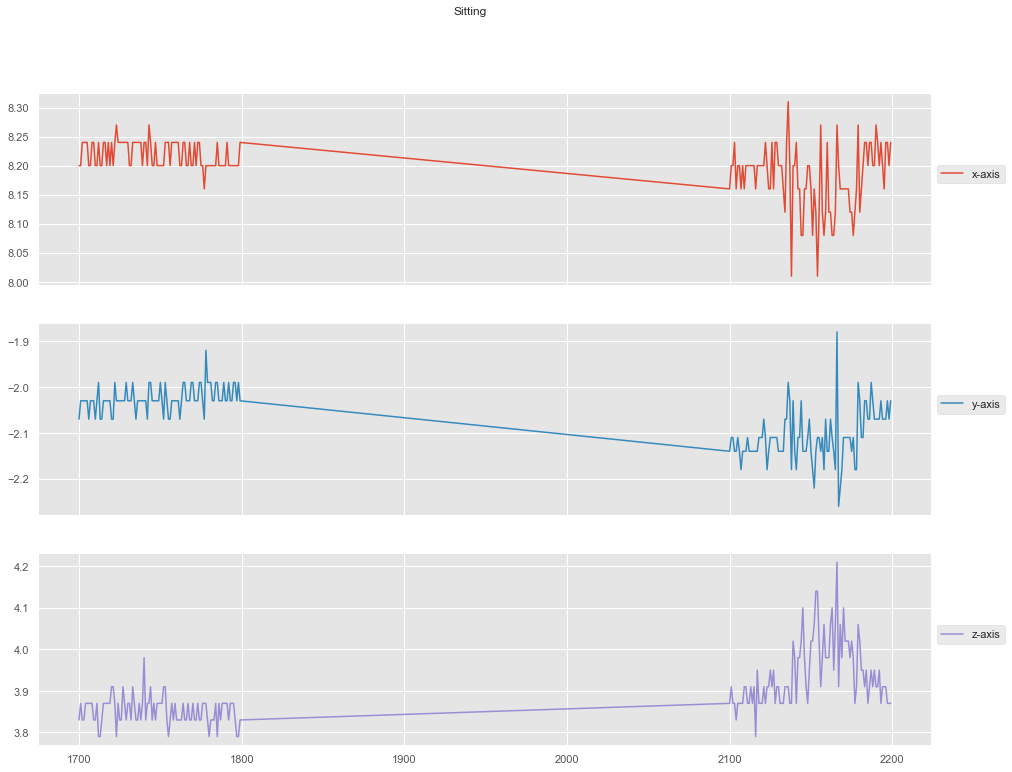

In [9]:

plot_activity("Sitting", merged)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

user_snippets = merged['user_snippet'].unique()
train_user_snippets, test_user_snippets = train_test_split(user_snippets, test_size=0.2, random_state=42)

# Split the dataset based on the user snippets
train_df = merged[merged['user_snippet'].isin(train_user_snippets)]
test_df = merged[merged['user_snippet'].isin(test_user_snippets)]
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape,)

Training set shape: (649289, 6)
Testing set shape: (162348, 6)


In [13]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
merged[LABEL] = le.fit_transform(merged['activity'].values.ravel())

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
merged['x-axis'] = merged['x-axis'] / merged['x-axis'].max()
merged['y-axis'] = merged['y-axis'] / merged['y-axis'].max()
merged['z-axis'] = merged['z-axis'] / merged['z-axis'].max()
# Round numbers
merged= merged.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(merged,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [14]:

print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (16231, 100, 3)
16231 training samples
y_train shape:  (16231,)


In [15]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [16]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (16231, 300)
input_shape: 300


In [17]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [18]:

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (16231, 6)


In [19]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 3)            0         
                                                                 
 dense (Dense)               (None, 100, 100)          400       
                                                                 
 dense_1 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 100, 100)          10100     
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 6)                 60006     
                                                                 
Total params: 80,606
Trainable params: 80,606
Non-traina

In [20]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
33/33 [==============================] - 20s 547ms/step - loss: 1.2729 - accuracy: 0.5430 - val_loss: 0.8412 - val_accuracy: 0.7268
Epoch 2/50
33/33 [==============================] - 13s 385ms/step - loss: 0.8100 - accuracy: 0.7076 - val_loss: 0.7416 - val_accuracy: 0.7333
Epoch 3/50
33/33 [==============================] - 14s 427ms/step - loss: 0.6991 - accuracy: 0.7493 - val_loss: 0.6969 - val_accuracy: 0.7607
Epoch 4/50
33/33 [==============================] - 13s 390ms/step - loss: 0.6540 - accuracy: 0.7669 - val_loss: 0.7268 - val_accuracy: 0.7431
Epoch 5/50
33/33 [==============================] - 13s 385ms/step - loss: 0.6262 - accuracy: 0.7773 - val_loss: 0.6676 - val_accuracy: 0.7632
Epoch 6/50
33/33 [==============================] - 14s 424ms/step - loss: 0.5919 - accuracy: 0.7897 - val_loss: 0.6740 - val_accuracy: 0.7743
Epoch 7/50
33/33 [==============================] - 14s 415ms/step - loss: 0.5759 - accuracy: 0.7953 - val_loss: 0.6392 - val_accuracy: 0.7739

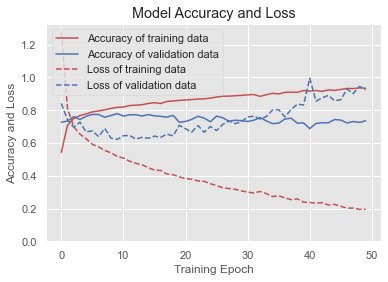

508/508 [==============================] - 9s 17ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72      1470
         1.0       0.98      0.95      0.96      4908
         2.0       0.99      0.99      0.99       989
         3.0       0.99      0.98      0.99       771
         4.0       0.69      0.78      0.73      1620
         5.0       0.89      0.93      0.91      6473

    accuracy                           0.90     16231
   macro avg       0.89      0.88      0.88     16231
weighted avg       0.90      0.90      0.90     16231



In [22]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

Test against the data

In [29]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
test_df[LABEL] = le.fit_transform(test_df['activity'].values.ravel())

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
# Normalize features for training data set
test_df['x-axis'] = test_df['x-axis'] / test_df['x-axis'].max()
test_df['y-axis'] = test_df['y-axis'] / test_df['y-axis'].max()
test_df['z-axis'] = test_df['z-axis'] / test_df['z-axis'].max()

test_df = test_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(test_df,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

102/102 [==============================] - 1s 7ms/step - loss: 0.9876 - accuracy: 0.7331

Accuracy on test data: 0.73

Loss on test data: 0.99


102/102 [==============================] - 0s 4ms/step


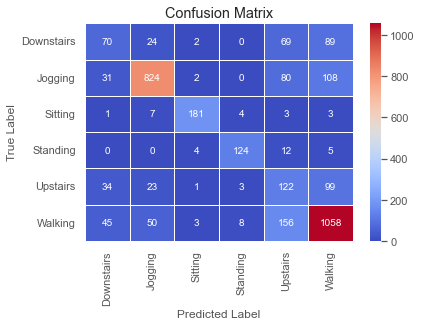

              precision    recall  f1-score   support

           0       0.39      0.28      0.32       254
           1       0.89      0.79      0.84      1045
           2       0.94      0.91      0.92       199
           3       0.89      0.86      0.87       145
           4       0.28      0.43      0.34       282
           5       0.78      0.80      0.79      1320

    accuracy                           0.73      3245
   macro avg       0.69      0.68      0.68      3245
weighted avg       0.75      0.73      0.74      3245



In [30]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))